<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


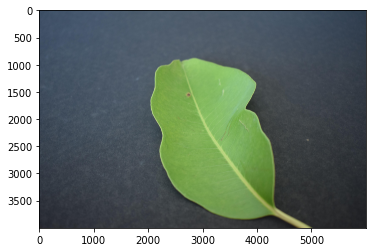

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

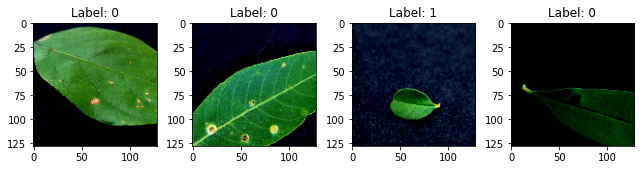

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:06] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:08] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2584099624402052 samples/sec                   batch loss = 0.8711208701133728 | accuracy = 0.3


Epoch[1] Batch[10] Speed: 1.2604711217815652 samples/sec                   batch loss = 0.534957766532898 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.257545098493064 samples/sec                   batch loss = 0.8291592597961426 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.2710462764891968 samples/sec                   batch loss = 0.7599254846572876 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2717000691137388 samples/sec                   batch loss = 0.9075842499732971 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2701170374653583 samples/sec                   batch loss = 0.9246677160263062 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.271346112911389 samples/sec                   batch loss = 0.3551376163959503 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.251858774061241 samples/sec                   batch loss = 0.44979602098464966 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.2598046978689021 samples/sec                   batch loss = 0.9140716791152954 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.2605969894683613 samples/sec                   batch loss = 1.2825372219085693 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2627006770342715 samples/sec                   batch loss = 0.3948742151260376 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.25496832623999 samples/sec                   batch loss = 0.7604470252990723 | accuracy = 0.6291666666666667


Epoch[1] Batch[65] Speed: 1.258108365401798 samples/sec                   batch loss = 0.8806297183036804 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.255844970977158 samples/sec                   batch loss = 1.1450728178024292 | accuracy = 0.6285714285714286


Epoch[1] Batch[75] Speed: 1.256505423080083 samples/sec                   batch loss = 0.5890130996704102 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.261261692005469 samples/sec                   batch loss = 0.24408000707626343 | accuracy = 0.640625


Epoch[1] Batch[85] Speed: 1.2694000370744478 samples/sec                   batch loss = 1.102679967880249 | accuracy = 0.65


Epoch[1] Batch[90] Speed: 1.2712426519188151 samples/sec                   batch loss = 0.34396809339523315 | accuracy = 0.6527777777777778


Epoch[1] Batch[95] Speed: 1.2722068208425696 samples/sec                   batch loss = 0.6523633599281311 | accuracy = 0.6552631578947369


Epoch[1] Batch[100] Speed: 1.2794838020061488 samples/sec                   batch loss = 0.6532361507415771 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.2677325749654262 samples/sec                   batch loss = 1.2037807703018188 | accuracy = 0.638095238095238


Epoch[1] Batch[110] Speed: 1.2632002805101255 samples/sec                   batch loss = 0.5516570210456848 | accuracy = 0.6386363636363637


Epoch[1] Batch[115] Speed: 1.266715491375392 samples/sec                   batch loss = 0.8443827629089355 | accuracy = 0.6456521739130435


Epoch[1] Batch[120] Speed: 1.2722557333807336 samples/sec                   batch loss = 0.7730849981307983 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.2674166314317241 samples/sec                   batch loss = 1.2597694396972656 | accuracy = 0.638


Epoch[1] Batch[130] Speed: 1.2698834260963778 samples/sec                   batch loss = 0.6787946224212646 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.273761704627597 samples/sec                   batch loss = 0.6950817108154297 | accuracy = 0.6333333333333333


Epoch[1] Batch[140] Speed: 1.2723395784125953 samples/sec                   batch loss = 0.5481170415878296 | accuracy = 0.6339285714285714


Epoch[1] Batch[145] Speed: 1.26554374646364 samples/sec                   batch loss = 0.19428107142448425 | accuracy = 0.6362068965517241


Epoch[1] Batch[150] Speed: 1.2723480696649567 samples/sec                   batch loss = 0.6426867246627808 | accuracy = 0.64


Epoch[1] Batch[155] Speed: 1.2698970750961456 samples/sec                   batch loss = 0.5270775556564331 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2591608079329788 samples/sec                   batch loss = 0.4488691985607147 | accuracy = 0.646875


Epoch[1] Batch[165] Speed: 1.2653625838979197 samples/sec                   batch loss = 0.6825733184814453 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.2647501843351356 samples/sec                   batch loss = 0.8334910869598389 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.2721987173532663 samples/sec                   batch loss = 0.8948727250099182 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2658897984569728 samples/sec                   batch loss = 0.36443522572517395 | accuracy = 0.6444444444444445


Epoch[1] Batch[185] Speed: 1.2639645681624254 samples/sec                   batch loss = 0.5038968324661255 | accuracy = 0.6445945945945946


Epoch[1] Batch[190] Speed: 1.2717866367168573 samples/sec                   batch loss = 0.3829069137573242 | accuracy = 0.6486842105263158


Epoch[1] Batch[195] Speed: 1.2665601915223923 samples/sec                   batch loss = 0.3869747519493103 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.270769970494763 samples/sec                   batch loss = 0.9082373380661011 | accuracy = 0.64875


Epoch[1] Batch[205] Speed: 1.2652352857112152 samples/sec                   batch loss = 0.47182613611221313 | accuracy = 0.651219512195122


Epoch[1] Batch[210] Speed: 1.270880285936429 samples/sec                   batch loss = 0.5740020275115967 | accuracy = 0.6547619047619048


Epoch[1] Batch[215] Speed: 1.2682719293617084 samples/sec                   batch loss = 0.6300172209739685 | accuracy = 0.6593023255813953


Epoch[1] Batch[220] Speed: 1.2644147606860023 samples/sec                   batch loss = 0.7795872688293457 | accuracy = 0.6590909090909091


Epoch[1] Batch[225] Speed: 1.269845075899836 samples/sec                   batch loss = 0.5792223811149597 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.2688457124049266 samples/sec                   batch loss = 0.4722757637500763 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.2736081529306085 samples/sec                   batch loss = 0.2861628532409668 | accuracy = 0.6563829787234042


Epoch[1] Batch[240] Speed: 1.2641930536662145 samples/sec                   batch loss = 0.4491260349750519 | accuracy = 0.6572916666666667


Epoch[1] Batch[245] Speed: 1.233617009386751 samples/sec                   batch loss = 0.5751236081123352 | accuracy = 0.6602040816326531


Epoch[1] Batch[250] Speed: 1.2679059846628957 samples/sec                   batch loss = 0.9528552889823914 | accuracy = 0.661


Epoch[1] Batch[255] Speed: 1.2675219603644028 samples/sec                   batch loss = 0.6963953971862793 | accuracy = 0.6607843137254902


Epoch[1] Batch[260] Speed: 1.2682819004283392 samples/sec                   batch loss = 0.7545810341835022 | accuracy = 0.6586538461538461


Epoch[1] Batch[265] Speed: 1.2739576625057225 samples/sec                   batch loss = 0.8353776931762695 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.272530948567566 samples/sec                   batch loss = 0.5041401982307434 | accuracy = 0.6564814814814814


Epoch[1] Batch[275] Speed: 1.2711989220747741 samples/sec                   batch loss = 0.8121362328529358 | accuracy = 0.6563636363636364


Epoch[1] Batch[280] Speed: 1.2690626228237412 samples/sec                   batch loss = 0.8427956700325012 | accuracy = 0.6526785714285714


Epoch[1] Batch[285] Speed: 1.2720529686439228 samples/sec                   batch loss = 0.5281916856765747 | accuracy = 0.6517543859649123


Epoch[1] Batch[290] Speed: 1.265702616599193 samples/sec                   batch loss = 0.6549360156059265 | accuracy = 0.6525862068965518


Epoch[1] Batch[295] Speed: 1.2668060686606544 samples/sec                   batch loss = 0.807932436466217 | accuracy = 0.6542372881355932


Epoch[1] Batch[300] Speed: 1.2644384889909652 samples/sec                   batch loss = 0.3187647759914398 | accuracy = 0.6583333333333333


Epoch[1] Batch[305] Speed: 1.2682450849615752 samples/sec                   batch loss = 0.7242865562438965 | accuracy = 0.6614754098360656


Epoch[1] Batch[310] Speed: 1.2703921938028497 samples/sec                   batch loss = 0.312092125415802 | accuracy = 0.6612903225806451


Epoch[1] Batch[315] Speed: 1.2694280829862508 samples/sec                   batch loss = 0.7988486886024475 | accuracy = 0.6603174603174603


Epoch[1] Batch[320] Speed: 1.265478835050348 samples/sec                   batch loss = 0.5011348128318787 | accuracy = 0.659375


Epoch[1] Batch[325] Speed: 1.2678154416376002 samples/sec                   batch loss = 0.35727474093437195 | accuracy = 0.6630769230769231


Epoch[1] Batch[330] Speed: 1.2630092341446089 samples/sec                   batch loss = 0.6069927215576172 | accuracy = 0.6636363636363637


Epoch[1] Batch[335] Speed: 1.268006699028121 samples/sec                   batch loss = 0.3456845283508301 | accuracy = 0.6611940298507463


Epoch[1] Batch[340] Speed: 1.2630909138955302 samples/sec                   batch loss = 0.2317521721124649 | accuracy = 0.6610294117647059


Epoch[1] Batch[345] Speed: 1.2639557123214469 samples/sec                   batch loss = 0.7108877897262573 | accuracy = 0.6608695652173913


Epoch[1] Batch[350] Speed: 1.2668400265249946 samples/sec                   batch loss = 0.4812582731246948 | accuracy = 0.6592857142857143


Epoch[1] Batch[355] Speed: 1.271885943692044 samples/sec                   batch loss = 0.40082526206970215 | accuracy = 0.6605633802816901


Epoch[1] Batch[360] Speed: 1.2687685639240283 samples/sec                   batch loss = 0.7776275873184204 | accuracy = 0.6590277777777778


Epoch[1] Batch[365] Speed: 1.2690062765723369 samples/sec                   batch loss = 0.39006590843200684 | accuracy = 0.6595890410958904


Epoch[1] Batch[370] Speed: 1.2641288522299339 samples/sec                   batch loss = 0.4469696283340454 | accuracy = 0.6594594594594595


Epoch[1] Batch[375] Speed: 1.2587880121586987 samples/sec                   batch loss = 0.31275475025177 | accuracy = 0.662


Epoch[1] Batch[380] Speed: 1.2571733528839495 samples/sec                   batch loss = 0.559687614440918 | accuracy = 0.6631578947368421


Epoch[1] Batch[385] Speed: 1.2611868850881625 samples/sec                   batch loss = 0.4689617156982422 | accuracy = 0.6636363636363637


Epoch[1] Batch[390] Speed: 1.2651036248820366 samples/sec                   batch loss = 0.2710309326648712 | accuracy = 0.6634615384615384


Epoch[1] Batch[395] Speed: 1.2694401853720485 samples/sec                   batch loss = 0.4307805299758911 | accuracy = 0.6651898734177215


Epoch[1] Batch[400] Speed: 1.2669367446722246 samples/sec                   batch loss = 0.5653754472732544 | accuracy = 0.66375


Epoch[1] Batch[405] Speed: 1.2638797285929124 samples/sec                   batch loss = 0.44927778840065 | accuracy = 0.6648148148148149


Epoch[1] Batch[410] Speed: 1.2707255031938525 samples/sec                   batch loss = 0.47591832280158997 | accuracy = 0.6664634146341464


Epoch[1] Batch[415] Speed: 1.2739886189182863 samples/sec                   batch loss = 0.49962949752807617 | accuracy = 0.6662650602409639


Epoch[1] Batch[420] Speed: 1.2611588229315818 samples/sec                   batch loss = 0.371969997882843 | accuracy = 0.6672619047619047


Epoch[1] Batch[425] Speed: 1.2660624177262454 samples/sec                   batch loss = 0.3877212107181549 | accuracy = 0.6670588235294118


Epoch[1] Batch[430] Speed: 1.2608685097991676 samples/sec                   batch loss = 0.7163922786712646 | accuracy = 0.6656976744186046


Epoch[1] Batch[435] Speed: 1.2617717342403152 samples/sec                   batch loss = 1.0937546491622925 | accuracy = 0.6637931034482759


Epoch[1] Batch[440] Speed: 1.2698399819377295 samples/sec                   batch loss = 0.3861759305000305 | accuracy = 0.6630681818181818


Epoch[1] Batch[445] Speed: 1.2732176718850186 samples/sec                   batch loss = 0.42541882395744324 | accuracy = 0.6651685393258427


Epoch[1] Batch[450] Speed: 1.2698207598073035 samples/sec                   batch loss = 0.7723397016525269 | accuracy = 0.6638888888888889


Epoch[1] Batch[455] Speed: 1.2720817106166238 samples/sec                   batch loss = 0.6485857963562012 | accuracy = 0.6637362637362637


Epoch[1] Batch[460] Speed: 1.2701816562752655 samples/sec                   batch loss = 0.3758973181247711 | accuracy = 0.6630434782608695


Epoch[1] Batch[465] Speed: 1.2724695648797157 samples/sec                   batch loss = 0.3660218119621277 | accuracy = 0.6661290322580645


Epoch[1] Batch[470] Speed: 1.2692563692366539 samples/sec                   batch loss = 0.3347148895263672 | accuracy = 0.6670212765957447


Epoch[1] Batch[475] Speed: 1.27140883349874 samples/sec                   batch loss = 0.4972338378429413 | accuracy = 0.6678947368421052


Epoch[1] Batch[480] Speed: 1.2691458554868689 samples/sec                   batch loss = 0.35994818806648254 | accuracy = 0.6677083333333333


Epoch[1] Batch[485] Speed: 1.2670809404841386 samples/sec                   batch loss = 0.5358814001083374 | accuracy = 0.668041237113402


Epoch[1] Batch[490] Speed: 1.2677720430582042 samples/sec                   batch loss = 0.6739760637283325 | accuracy = 0.6678571428571428


Epoch[1] Batch[495] Speed: 1.2692537765998373 samples/sec                   batch loss = 0.4084620475769043 | accuracy = 0.6666666666666666


Epoch[1] Batch[500] Speed: 1.2715051905421906 samples/sec                   batch loss = 0.4560341536998749 | accuracy = 0.667


Epoch[1] Batch[505] Speed: 1.2760554551029657 samples/sec                   batch loss = 0.30526334047317505 | accuracy = 0.6678217821782179


Epoch[1] Batch[510] Speed: 1.2690165471515609 samples/sec                   batch loss = 0.4493885636329651 | accuracy = 0.6686274509803921


Epoch[1] Batch[515] Speed: 1.2685158819893931 samples/sec                   batch loss = 0.5971407890319824 | accuracy = 0.6694174757281554


Epoch[1] Batch[520] Speed: 1.2682437427713986 samples/sec                   batch loss = 1.6942992210388184 | accuracy = 0.6682692307692307


Epoch[1] Batch[525] Speed: 1.2676930135426134 samples/sec                   batch loss = 0.3060535192489624 | accuracy = 0.6695238095238095


Epoch[1] Batch[530] Speed: 1.270122710579728 samples/sec                   batch loss = 0.9930542707443237 | accuracy = 0.6669811320754717


Epoch[1] Batch[535] Speed: 1.2643385311947042 samples/sec                   batch loss = 0.38974475860595703 | accuracy = 0.6668224299065421


Epoch[1] Batch[540] Speed: 1.2678767603683316 samples/sec                   batch loss = 0.3389078974723816 | accuracy = 0.6685185185185185


Epoch[1] Batch[545] Speed: 1.2706190638118686 samples/sec                   batch loss = 0.6612187027931213 | accuracy = 0.6678899082568808


Epoch[1] Batch[550] Speed: 1.2663336215135514 samples/sec                   batch loss = 0.45020827651023865 | accuracy = 0.6686363636363636


Epoch[1] Batch[555] Speed: 1.2722927820666434 samples/sec                   batch loss = 0.3364558815956116 | accuracy = 0.668918918918919


Epoch[1] Batch[560] Speed: 1.2628177702976318 samples/sec                   batch loss = 0.6545523405075073 | accuracy = 0.6691964285714286


Epoch[1] Batch[565] Speed: 1.2664462271907493 samples/sec                   batch loss = 0.2292000949382782 | accuracy = 0.6699115044247788


Epoch[1] Batch[570] Speed: 1.2633402022854439 samples/sec                   batch loss = 0.6733573079109192 | accuracy = 0.668859649122807


Epoch[1] Batch[575] Speed: 1.2630919599212687 samples/sec                   batch loss = 0.9985513091087341 | accuracy = 0.6678260869565218


Epoch[1] Batch[580] Speed: 1.261638705978573 samples/sec                   batch loss = 0.6497448086738586 | accuracy = 0.6681034482758621


Epoch[1] Batch[585] Speed: 1.2641921963340481 samples/sec                   batch loss = 0.1895163357257843 | accuracy = 0.6679487179487179


Epoch[1] Batch[590] Speed: 1.270545163410285 samples/sec                   batch loss = 0.3758572041988373 | accuracy = 0.6686440677966101


Epoch[1] Batch[595] Speed: 1.266837061117815 samples/sec                   batch loss = 0.18148332834243774 | accuracy = 0.6701680672268907


Epoch[1] Batch[600] Speed: 1.2646354968972846 samples/sec                   batch loss = 0.8904542922973633 | accuracy = 0.6704166666666667


Epoch[1] Batch[605] Speed: 1.2734457455869264 samples/sec                   batch loss = 0.5258128046989441 | accuracy = 0.6694214876033058


Epoch[1] Batch[610] Speed: 1.2701576157714038 samples/sec                   batch loss = 0.4266682267189026 | accuracy = 0.6704918032786885


Epoch[1] Batch[615] Speed: 1.2658993500361686 samples/sec                   batch loss = 0.7091665863990784 | accuracy = 0.6711382113821138


Epoch[1] Batch[620] Speed: 1.266095475817714 samples/sec                   batch loss = 0.4796152412891388 | accuracy = 0.6697580645161291


Epoch[1] Batch[625] Speed: 1.2633240302717967 samples/sec                   batch loss = 0.5439805388450623 | accuracy = 0.6704


Epoch[1] Batch[630] Speed: 1.270542180631861 samples/sec                   batch loss = 0.7410688996315002 | accuracy = 0.6706349206349206


Epoch[1] Batch[635] Speed: 1.2674113654446029 samples/sec                   batch loss = 0.43166685104370117 | accuracy = 0.6724409448818898


Epoch[1] Batch[640] Speed: 1.2649872518944971 samples/sec                   batch loss = 0.28494957089424133 | accuracy = 0.673046875


Epoch[1] Batch[645] Speed: 1.2716463799853608 samples/sec                   batch loss = 0.5039912462234497 | accuracy = 0.6732558139534883


Epoch[1] Batch[650] Speed: 1.2743179141103922 samples/sec                   batch loss = 0.3673231303691864 | accuracy = 0.6742307692307692


Epoch[1] Batch[655] Speed: 1.2650485835136969 samples/sec                   batch loss = 0.72392338514328 | accuracy = 0.6748091603053435


Epoch[1] Batch[660] Speed: 1.278069906941376 samples/sec                   batch loss = 0.7961848378181458 | accuracy = 0.6753787878787879


Epoch[1] Batch[665] Speed: 1.2760180899113804 samples/sec                   batch loss = 0.3054797947406769 | accuracy = 0.6763157894736842


Epoch[1] Batch[670] Speed: 1.276502842668352 samples/sec                   batch loss = 0.30019116401672363 | accuracy = 0.676865671641791


Epoch[1] Batch[675] Speed: 1.2749579281459469 samples/sec                   batch loss = 0.7493497729301453 | accuracy = 0.677037037037037


Epoch[1] Batch[680] Speed: 1.270750335198975 samples/sec                   batch loss = 0.7935234308242798 | accuracy = 0.6775735294117647


Epoch[1] Batch[685] Speed: 1.2728244367006922 samples/sec                   batch loss = 0.5285653471946716 | accuracy = 0.6788321167883211


Epoch[1] Batch[690] Speed: 1.276127474190831 samples/sec                   batch loss = 0.331318736076355 | accuracy = 0.6800724637681159


Epoch[1] Batch[695] Speed: 1.2772633829054159 samples/sec                   batch loss = 0.5832948684692383 | accuracy = 0.6794964028776979


Epoch[1] Batch[700] Speed: 1.2648728075449593 samples/sec                   batch loss = 1.669272780418396 | accuracy = 0.6782142857142858


Epoch[1] Batch[705] Speed: 1.2680329583046472 samples/sec                   batch loss = 0.5974283814430237 | accuracy = 0.6783687943262411


Epoch[1] Batch[710] Speed: 1.2681960968606032 samples/sec                   batch loss = 0.6777075529098511 | accuracy = 0.6795774647887324


Epoch[1] Batch[715] Speed: 1.2696772849885922 samples/sec                   batch loss = 0.5100371837615967 | accuracy = 0.6804195804195804


Epoch[1] Batch[720] Speed: 1.2646557063075634 samples/sec                   batch loss = 0.5542489290237427 | accuracy = 0.68125


Epoch[1] Batch[725] Speed: 1.2634449498811842 samples/sec                   batch loss = 0.8083893656730652 | accuracy = 0.6817241379310345


Epoch[1] Batch[730] Speed: 1.2747079082082322 samples/sec                   batch loss = 0.9363673329353333 | accuracy = 0.6818493150684931


Epoch[1] Batch[735] Speed: 1.269224106066037 samples/sec                   batch loss = 0.9911595582962036 | accuracy = 0.6806122448979591


Epoch[1] Batch[740] Speed: 1.266370326087859 samples/sec                   batch loss = 0.9571818113327026 | accuracy = 0.6800675675675676


Epoch[1] Batch[745] Speed: 1.2605198937110733 samples/sec                   batch loss = 0.7527086734771729 | accuracy = 0.6795302013422819


Epoch[1] Batch[750] Speed: 1.2670340517153489 samples/sec                   batch loss = 0.5421291589736938 | accuracy = 0.6803333333333333


Epoch[1] Batch[755] Speed: 1.2695386458948392 samples/sec                   batch loss = 0.4383334219455719 | accuracy = 0.6798013245033112


Epoch[1] Batch[760] Speed: 1.2645541891464402 samples/sec                   batch loss = 0.43112099170684814 | accuracy = 0.6802631578947368


Epoch[1] Batch[765] Speed: 1.2691305905477501 samples/sec                   batch loss = 0.6745778322219849 | accuracy = 0.680718954248366


Epoch[1] Batch[770] Speed: 1.2648126371980248 samples/sec                   batch loss = 0.8437349796295166 | accuracy = 0.6805194805194805


Epoch[1] Batch[775] Speed: 1.2599117930415946 samples/sec                   batch loss = 0.7219281196594238 | accuracy = 0.68


Epoch[1] Batch[780] Speed: 1.2554374964128414 samples/sec                   batch loss = 0.24651716649532318 | accuracy = 0.6798076923076923


Epoch[1] Batch[785] Speed: 1.2543426860172535 samples/sec                   batch loss = 0.620244562625885 | accuracy = 0.6808917197452229


[Epoch 1] training: accuracy=0.6811548223350253
[Epoch 1] time cost: 648.9601364135742
[Epoch 1] validation: validation accuracy=0.7533333333333333


Epoch[2] Batch[5] Speed: 1.2606401823678104 samples/sec                   batch loss = 0.5222904682159424 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2579796927785758 samples/sec                   batch loss = 0.2710479199886322 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2598194554859636 samples/sec                   batch loss = 0.28076934814453125 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2553908078470906 samples/sec                   batch loss = 0.5567303895950317 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2595824294379776 samples/sec                   batch loss = 0.5703243017196655 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.2667896164909316 samples/sec                   batch loss = 0.7883791327476501 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.26028014261407 samples/sec                   batch loss = 0.42313385009765625 | accuracy = 0.7928571428571428


Epoch[2] Batch[40] Speed: 1.2660193301465301 samples/sec                   batch loss = 0.6026014685630798 | accuracy = 0.78125


Epoch[2] Batch[45] Speed: 1.259435680688934 samples/sec                   batch loss = 0.9149292707443237 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.2702696522805579 samples/sec                   batch loss = 0.5703302025794983 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.2632909264998082 samples/sec                   batch loss = 0.6020532250404358 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.264642837032927 samples/sec                   batch loss = 0.8825601935386658 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2587240752094646 samples/sec                   batch loss = 0.7909162640571594 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2588961625509139 samples/sec                   batch loss = 0.40106624364852905 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.261600567528713 samples/sec                   batch loss = 0.5053828954696655 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.262401959500722 samples/sec                   batch loss = 0.9002020359039307 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2641399012707166 samples/sec                   batch loss = 0.3514469861984253 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2637504439490543 samples/sec                   batch loss = 0.7246989011764526 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2604360840842863 samples/sec                   batch loss = 0.4565366208553314 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.2670934766408657 samples/sec                   batch loss = 0.3198206126689911 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2666992328327356 samples/sec                   batch loss = 0.4149357080459595 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2682908169957097 samples/sec                   batch loss = 0.5809491276741028 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2610947397158623 samples/sec                   batch loss = 0.8073980808258057 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.2625053164959317 samples/sec                   batch loss = 0.5850659012794495 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2738468121932685 samples/sec                   batch loss = 0.41516610980033875 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.264026657758245 samples/sec                   batch loss = 0.4106081426143646 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.266490013073131 samples/sec                   batch loss = 1.0202345848083496 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2595501833858034 samples/sec                   batch loss = 0.27003583312034607 | accuracy = 0.7357142857142858


Epoch[2] Batch[145] Speed: 1.2597828458786626 samples/sec                   batch loss = 0.29019680619239807 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.256815666986566 samples/sec                   batch loss = 0.2960147261619568 | accuracy = 0.7416666666666667


Epoch[2] Batch[155] Speed: 1.2550048443146775 samples/sec                   batch loss = 0.6163612604141235 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2567084385570593 samples/sec                   batch loss = 0.5790597796440125 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.248846951038639 samples/sec                   batch loss = 0.6635686755180359 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.2525367331138915 samples/sec                   batch loss = 0.982162594795227 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.2592120302774412 samples/sec                   batch loss = 0.8622646331787109 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2547959032716416 samples/sec                   batch loss = 0.6256310939788818 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2573084562778618 samples/sec                   batch loss = 0.3723931312561035 | accuracy = 0.731081081081081


Epoch[2] Batch[190] Speed: 1.2578173801928814 samples/sec                   batch loss = 0.6211846470832825 | accuracy = 0.7289473684210527


Epoch[2] Batch[195] Speed: 1.2692328438461231 samples/sec                   batch loss = 0.6166682243347168 | accuracy = 0.7307692307692307


Epoch[2] Batch[200] Speed: 1.2556798254510009 samples/sec                   batch loss = 0.8924776315689087 | accuracy = 0.7325


Epoch[2] Batch[205] Speed: 1.2524830603044501 samples/sec                   batch loss = 0.16883713006973267 | accuracy = 0.7317073170731707


Epoch[2] Batch[210] Speed: 1.2657938130889408 samples/sec                   batch loss = 0.43094778060913086 | accuracy = 0.7357142857142858


Epoch[2] Batch[215] Speed: 1.2554874767540998 samples/sec                   batch loss = 0.26939141750335693 | accuracy = 0.7325581395348837


Epoch[2] Batch[220] Speed: 1.2597365902702613 samples/sec                   batch loss = 0.3716150224208832 | accuracy = 0.7306818181818182


Epoch[2] Batch[225] Speed: 1.2522425242412207 samples/sec                   batch loss = 0.2525492310523987 | accuracy = 0.7344444444444445


Epoch[2] Batch[230] Speed: 1.2581050633558766 samples/sec                   batch loss = 0.5268064737319946 | accuracy = 0.7347826086956522


Epoch[2] Batch[235] Speed: 1.256869711777722 samples/sec                   batch loss = 0.4611351788043976 | accuracy = 0.7340425531914894


Epoch[2] Batch[240] Speed: 1.2633997569170943 samples/sec                   batch loss = 0.3701535165309906 | accuracy = 0.7354166666666667


Epoch[2] Batch[245] Speed: 1.2578617974289028 samples/sec                   batch loss = 0.5167644023895264 | accuracy = 0.7357142857142858


Epoch[2] Batch[250] Speed: 1.2643938919490338 samples/sec                   batch loss = 0.2515247166156769 | accuracy = 0.734


Epoch[2] Batch[255] Speed: 1.263462361928017 samples/sec                   batch loss = 0.4190855622291565 | accuracy = 0.7313725490196078


Epoch[2] Batch[260] Speed: 1.2675621814844316 samples/sec                   batch loss = 0.5714538097381592 | accuracy = 0.7307692307692307


Epoch[2] Batch[265] Speed: 1.2665101861905288 samples/sec                   batch loss = 0.3222947418689728 | accuracy = 0.7330188679245283


Epoch[2] Batch[270] Speed: 1.2655735315760566 samples/sec                   batch loss = 0.34036314487457275 | accuracy = 0.7305555555555555


Epoch[2] Batch[275] Speed: 1.266001083297226 samples/sec                   batch loss = 0.6131781339645386 | accuracy = 0.7272727272727273


Epoch[2] Batch[280] Speed: 1.2618562910326472 samples/sec                   batch loss = 0.42236536741256714 | accuracy = 0.725


Epoch[2] Batch[285] Speed: 1.2699743608822958 samples/sec                   batch loss = 0.4152635633945465 | accuracy = 0.724561403508772


Epoch[2] Batch[290] Speed: 1.2614555296597634 samples/sec                   batch loss = 0.19100028276443481 | accuracy = 0.7258620689655172


Epoch[2] Batch[295] Speed: 1.2645220692702255 samples/sec                   batch loss = 0.4985649883747101 | accuracy = 0.726271186440678


Epoch[2] Batch[300] Speed: 1.2696960223237188 samples/sec                   batch loss = 0.4555109441280365 | accuracy = 0.7275


Epoch[2] Batch[305] Speed: 1.266840122183522 samples/sec                   batch loss = 0.42885059118270874 | accuracy = 0.728688524590164


Epoch[2] Batch[310] Speed: 1.2690361289034253 samples/sec                   batch loss = 0.7840739488601685 | accuracy = 0.7274193548387097


Epoch[2] Batch[315] Speed: 1.265952363920739 samples/sec                   batch loss = 0.4537668526172638 | accuracy = 0.7285714285714285


Epoch[2] Batch[320] Speed: 1.2682292664721977 samples/sec                   batch loss = 0.34566253423690796 | accuracy = 0.728125


Epoch[2] Batch[325] Speed: 1.266623301401278 samples/sec                   batch loss = 0.315818190574646 | accuracy = 0.7284615384615385


Epoch[2] Batch[330] Speed: 1.268344702576354 samples/sec                   batch loss = 0.72539883852005 | accuracy = 0.7303030303030303


Epoch[2] Batch[335] Speed: 1.2708202165146176 samples/sec                   batch loss = 0.53975909948349 | accuracy = 0.7313432835820896


Epoch[2] Batch[340] Speed: 1.270122133650528 samples/sec                   batch loss = 0.42021334171295166 | accuracy = 0.7323529411764705


Epoch[2] Batch[345] Speed: 1.2613980549442791 samples/sec                   batch loss = 0.34782156348228455 | accuracy = 0.7326086956521739


Epoch[2] Batch[350] Speed: 1.2655714312978266 samples/sec                   batch loss = 0.23523855209350586 | accuracy = 0.7328571428571429


Epoch[2] Batch[355] Speed: 1.261976360268438 samples/sec                   batch loss = 0.5144055485725403 | accuracy = 0.7338028169014085


Epoch[2] Batch[360] Speed: 1.2615048520730348 samples/sec                   batch loss = 0.4413299560546875 | accuracy = 0.7347222222222223


Epoch[2] Batch[365] Speed: 1.2654241428081812 samples/sec                   batch loss = 0.40771573781967163 | accuracy = 0.7349315068493151


Epoch[2] Batch[370] Speed: 1.272694763903634 samples/sec                   batch loss = 0.48562169075012207 | accuracy = 0.7358108108108108


Epoch[2] Batch[375] Speed: 1.2642735528108682 samples/sec                   batch loss = 0.26157835125923157 | accuracy = 0.7366666666666667


Epoch[2] Batch[380] Speed: 1.2716699949321832 samples/sec                   batch loss = 0.44911476969718933 | accuracy = 0.7388157894736842


Epoch[2] Batch[385] Speed: 1.2612690878481367 samples/sec                   batch loss = 0.3758682608604431 | accuracy = 0.7389610389610389


Epoch[2] Batch[390] Speed: 1.2632415594421027 samples/sec                   batch loss = 1.287509560585022 | accuracy = 0.7391025641025641


Epoch[2] Batch[395] Speed: 1.270994568285969 samples/sec                   batch loss = 0.5551297068595886 | accuracy = 0.739240506329114


Epoch[2] Batch[400] Speed: 1.265924566897823 samples/sec                   batch loss = 0.5858672261238098 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.2700246401441315 samples/sec                   batch loss = 0.22767247259616852 | accuracy = 0.7382716049382716


Epoch[2] Batch[410] Speed: 1.2670180720503128 samples/sec                   batch loss = 0.4647933840751648 | accuracy = 0.7390243902439024


Epoch[2] Batch[415] Speed: 1.2653207845174455 samples/sec                   batch loss = 0.5738219022750854 | accuracy = 0.7379518072289156


Epoch[2] Batch[420] Speed: 1.2656147748155784 samples/sec                   batch loss = 0.5322772264480591 | accuracy = 0.7398809523809524


Epoch[2] Batch[425] Speed: 1.2653271783076978 samples/sec                   batch loss = 0.7164216041564941 | accuracy = 0.7382352941176471


Epoch[2] Batch[430] Speed: 1.2661296822498405 samples/sec                   batch loss = 0.3143880367279053 | accuracy = 0.7372093023255814


Epoch[2] Batch[435] Speed: 1.2658406101066455 samples/sec                   batch loss = 0.5813477039337158 | accuracy = 0.7373563218390805


Epoch[2] Batch[440] Speed: 1.2733601117281885 samples/sec                   batch loss = 0.34406179189682007 | accuracy = 0.7375


Epoch[2] Batch[445] Speed: 1.266047991181169 samples/sec                   batch loss = 0.3334866464138031 | accuracy = 0.7382022471910112


Epoch[2] Batch[450] Speed: 1.2649380382863322 samples/sec                   batch loss = 0.4553447961807251 | accuracy = 0.7394444444444445


Epoch[2] Batch[455] Speed: 1.2666650912516373 samples/sec                   batch loss = 0.8666803240776062 | accuracy = 0.739010989010989


Epoch[2] Batch[460] Speed: 1.27249465812452 samples/sec                   batch loss = 0.3637615740299225 | accuracy = 0.7407608695652174


Epoch[2] Batch[465] Speed: 1.2677817188637854 samples/sec                   batch loss = 0.5282401442527771 | accuracy = 0.7408602150537634


Epoch[2] Batch[470] Speed: 1.269984166467899 samples/sec                   batch loss = 0.34697961807250977 | accuracy = 0.7425531914893617


Epoch[2] Batch[475] Speed: 1.269965036103119 samples/sec                   batch loss = 0.2635873258113861 | accuracy = 0.7447368421052631


Epoch[2] Batch[480] Speed: 1.2699534043540288 samples/sec                   batch loss = 0.9386457204818726 | accuracy = 0.74375


Epoch[2] Batch[485] Speed: 1.2689781533137625 samples/sec                   batch loss = 0.25751975178718567 | accuracy = 0.743298969072165


Epoch[2] Batch[490] Speed: 1.264043038239051 samples/sec                   batch loss = 0.02534351497888565 | accuracy = 0.7438775510204082


Epoch[2] Batch[495] Speed: 1.2703290925467918 samples/sec                   batch loss = 0.38599300384521484 | accuracy = 0.7449494949494949


Epoch[2] Batch[500] Speed: 1.2622431571005661 samples/sec                   batch loss = 0.47957658767700195 | accuracy = 0.7445


Epoch[2] Batch[505] Speed: 1.2640371335981972 samples/sec                   batch loss = 0.7023535966873169 | accuracy = 0.745049504950495


Epoch[2] Batch[510] Speed: 1.2641976261240737 samples/sec                   batch loss = 0.591961145401001 | accuracy = 0.7441176470588236


Epoch[2] Batch[515] Speed: 1.2678728319593247 samples/sec                   batch loss = 0.33794447779655457 | accuracy = 0.7451456310679612


Epoch[2] Batch[520] Speed: 1.2669351182311557 samples/sec                   batch loss = 0.2774514853954315 | accuracy = 0.7451923076923077


Epoch[2] Batch[525] Speed: 1.2664924988253936 samples/sec                   batch loss = 1.7049658298492432 | accuracy = 0.7428571428571429


Epoch[2] Batch[530] Speed: 1.2615569293451494 samples/sec                   batch loss = 1.087432622909546 | accuracy = 0.7415094339622641


Epoch[2] Batch[535] Speed: 1.2587248307041776 samples/sec                   batch loss = 0.21654300391674042 | accuracy = 0.7439252336448599


Epoch[2] Batch[540] Speed: 1.2582733954314547 samples/sec                   batch loss = 0.37569284439086914 | accuracy = 0.7430555555555556


Epoch[2] Batch[545] Speed: 1.261441871827216 samples/sec                   batch loss = 0.3478694558143616 | accuracy = 0.744954128440367


Epoch[2] Batch[550] Speed: 1.2569041748204812 samples/sec                   batch loss = 0.4991961717605591 | accuracy = 0.7436363636363637


Epoch[2] Batch[555] Speed: 1.2657935265872444 samples/sec                   batch loss = 0.19941329956054688 | accuracy = 0.7441441441441441


Epoch[2] Batch[560] Speed: 1.2665073179355948 samples/sec                   batch loss = 0.250843346118927 | accuracy = 0.74375


Epoch[2] Batch[565] Speed: 1.2622848483603637 samples/sec                   batch loss = 0.6237916350364685 | accuracy = 0.7429203539823008


Epoch[2] Batch[570] Speed: 1.2591473887456623 samples/sec                   batch loss = 0.5246630907058716 | accuracy = 0.743859649122807


Epoch[2] Batch[575] Speed: 1.2668388786237943 samples/sec                   batch loss = 0.6251087784767151 | accuracy = 0.7452173913043478


Epoch[2] Batch[580] Speed: 1.2640234198064804 samples/sec                   batch loss = 0.8414694666862488 | accuracy = 0.7456896551724138


Epoch[2] Batch[585] Speed: 1.267135488928851 samples/sec                   batch loss = 0.49809199571609497 | accuracy = 0.7461538461538462


Epoch[2] Batch[590] Speed: 1.2634261111579264 samples/sec                   batch loss = 0.24591372907161713 | accuracy = 0.7483050847457627


Epoch[2] Batch[595] Speed: 1.2634102223684816 samples/sec                   batch loss = 0.4237813949584961 | accuracy = 0.7487394957983193


Epoch[2] Batch[600] Speed: 1.2701747325168495 samples/sec                   batch loss = 0.3064664602279663 | accuracy = 0.7495833333333334


Epoch[2] Batch[605] Speed: 1.262800946309484 samples/sec                   batch loss = 0.45029544830322266 | accuracy = 0.7483471074380166


Epoch[2] Batch[610] Speed: 1.2657233375797678 samples/sec                   batch loss = 0.5394104719161987 | accuracy = 0.7483606557377049


Epoch[2] Batch[615] Speed: 1.2690002294866263 samples/sec                   batch loss = 0.8341037034988403 | accuracy = 0.7483739837398374


Epoch[2] Batch[620] Speed: 1.2666010209833913 samples/sec                   batch loss = 0.31348299980163574 | accuracy = 0.7491935483870967


Epoch[2] Batch[625] Speed: 1.2591130860669302 samples/sec                   batch loss = 0.39951130747795105 | accuracy = 0.75


Epoch[2] Batch[630] Speed: 1.2650880754485587 samples/sec                   batch loss = 1.087620496749878 | accuracy = 0.75


Epoch[2] Batch[635] Speed: 1.265599308285748 samples/sec                   batch loss = 0.8173814415931702 | accuracy = 0.7496062992125985


Epoch[2] Batch[640] Speed: 1.2744743478211988 samples/sec                   batch loss = 0.8117254376411438 | accuracy = 0.7484375


Epoch[2] Batch[645] Speed: 1.2628938165142862 samples/sec                   batch loss = 0.3699037730693817 | accuracy = 0.7484496124031008


Epoch[2] Batch[650] Speed: 1.2651676391523208 samples/sec                   batch loss = 0.5009782314300537 | accuracy = 0.7484615384615385


Epoch[2] Batch[655] Speed: 1.2670614190240588 samples/sec                   batch loss = 0.3977448344230652 | accuracy = 0.749236641221374


Epoch[2] Batch[660] Speed: 1.2754390636936657 samples/sec                   batch loss = 0.5341446995735168 | accuracy = 0.7503787878787879


Epoch[2] Batch[665] Speed: 1.2762044523649527 samples/sec                   batch loss = 0.39917171001434326 | accuracy = 0.750375939849624


Epoch[2] Batch[670] Speed: 1.268284584973066 samples/sec                   batch loss = 0.31981486082077026 | accuracy = 0.7511194029850746


Epoch[2] Batch[675] Speed: 1.2676251039277513 samples/sec                   batch loss = 0.47382253408432007 | accuracy = 0.7518518518518519


Epoch[2] Batch[680] Speed: 1.2632927338448836 samples/sec                   batch loss = 0.5971577167510986 | accuracy = 0.7518382352941176


Epoch[2] Batch[685] Speed: 1.2677851677014784 samples/sec                   batch loss = 0.7253912091255188 | accuracy = 0.7521897810218978


Epoch[2] Batch[690] Speed: 1.2702923504959278 samples/sec                   batch loss = 0.5746228694915771 | accuracy = 0.7518115942028986


Epoch[2] Batch[695] Speed: 1.2670934766408657 samples/sec                   batch loss = 0.7365755438804626 | accuracy = 0.7507194244604316


Epoch[2] Batch[700] Speed: 1.2713561323748335 samples/sec                   batch loss = 0.17248915135860443 | accuracy = 0.7510714285714286


Epoch[2] Batch[705] Speed: 1.260660643195402 samples/sec                   batch loss = 0.2630518674850464 | accuracy = 0.7510638297872341


Epoch[2] Batch[710] Speed: 1.2542602583816131 samples/sec                   batch loss = 0.34292545914649963 | accuracy = 0.7517605633802817


Epoch[2] Batch[715] Speed: 1.2492845765417653 samples/sec                   batch loss = 0.3694884181022644 | accuracy = 0.7517482517482518


Epoch[2] Batch[720] Speed: 1.2587083044643919 samples/sec                   batch loss = 0.5193981528282166 | accuracy = 0.7510416666666667


Epoch[2] Batch[725] Speed: 1.2653314726807086 samples/sec                   batch loss = 0.34588244557380676 | accuracy = 0.7520689655172413


Epoch[2] Batch[730] Speed: 1.2649124792410231 samples/sec                   batch loss = 0.27989211678504944 | accuracy = 0.7527397260273972


Epoch[2] Batch[735] Speed: 1.2562481009010995 samples/sec                   batch loss = 0.8496979475021362 | accuracy = 0.7520408163265306


Epoch[2] Batch[740] Speed: 1.2633012950234008 samples/sec                   batch loss = 0.21042174100875854 | accuracy = 0.7523648648648649


Epoch[2] Batch[745] Speed: 1.270110210564407 samples/sec                   batch loss = 0.3058509826660156 | accuracy = 0.7536912751677852


Epoch[2] Batch[750] Speed: 1.2672638398468636 samples/sec                   batch loss = 0.5098722577095032 | accuracy = 0.7536666666666667


Epoch[2] Batch[755] Speed: 1.2649165800630542 samples/sec                   batch loss = 0.5771907567977905 | accuracy = 0.7543046357615895


Epoch[2] Batch[760] Speed: 1.2659860849720248 samples/sec                   batch loss = 0.17167185246944427 | accuracy = 0.7546052631578948


Epoch[2] Batch[765] Speed: 1.2653818621682997 samples/sec                   batch loss = 0.9558761715888977 | accuracy = 0.7542483660130719


Epoch[2] Batch[770] Speed: 1.2658909446388658 samples/sec                   batch loss = 0.3288997411727905 | accuracy = 0.7542207792207792


Epoch[2] Batch[775] Speed: 1.269222377728184 samples/sec                   batch loss = 0.04201687499880791 | accuracy = 0.7545161290322581


Epoch[2] Batch[780] Speed: 1.2634805356690866 samples/sec                   batch loss = 0.13645383715629578 | accuracy = 0.7551282051282051


Epoch[2] Batch[785] Speed: 1.2688420658724524 samples/sec                   batch loss = 0.784552812576294 | accuracy = 0.7547770700636943


[Epoch 2] training: accuracy=0.753489847715736
[Epoch 2] time cost: 641.2569253444672
[Epoch 2] validation: validation accuracy=0.7411111111111112


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)